# Taxi Orders Prediction - Time Series Forecasting - Sweet Lift Taxi Company

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. This project comprises the building of a model for such a prediction. The RMSE metric on the test set should not be more than 48.

## Data Preprocessing

In [1]:
# Load packages
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
# load dataset
try:
    df = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
except Exception:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
# set global constants and settings
sns.set_style('darkgrid')

In [4]:
# take a look at the data
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
print(f'Data in chronological order: {df.index.is_monotonic_increasing}')

Data in chronological order: True


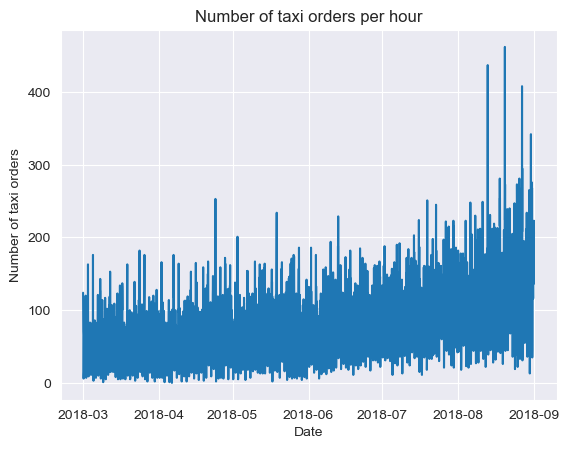

In [7]:
# resample the data to hourly frequency
df = df.resample('1H').sum()

# plot the data
g = sns.lineplot(data=df, x=df.index, y='num_orders')
g.set_title('Number of taxi orders per hour')
g.set_xlabel('Date')
g.set_ylabel('Number of taxi orders')

plt.show()

In [8]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


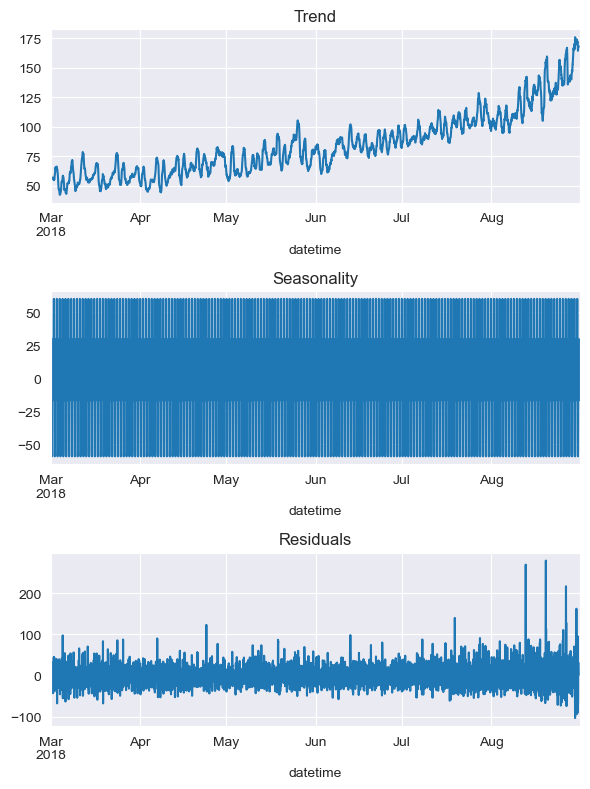

In [9]:
# decompose the time series into trend, seasonality and residuals
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

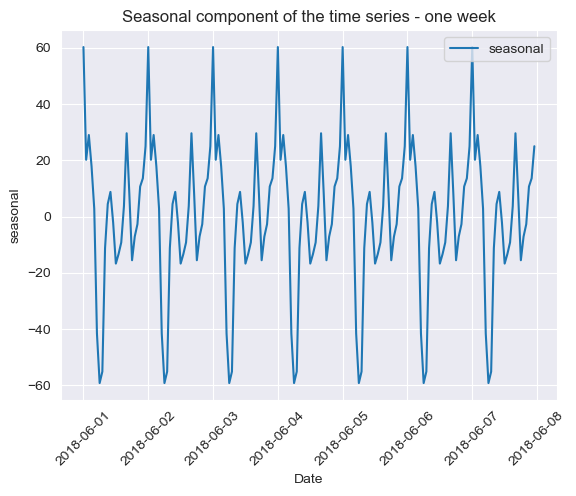

In [10]:
# Zoom in on the seasonal component of the time series for one week
decomposed_week = decomposed.seasonal['2018-06-01':'2018-06-07']

g = sns.lineplot(data=decomposed_week, label='seasonal')
g.set_title('Seasonal component of the time series - one week')
g.tick_params(axis='x', rotation=45)
g.set_xlabel('Date')

plt.show()


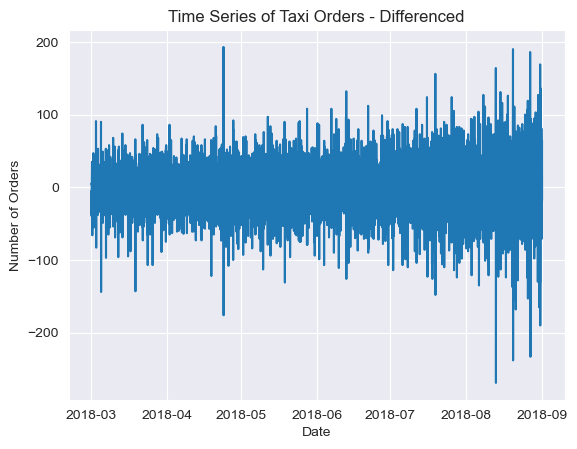

In [11]:
# Apply differencing to the data
df_diff = df - df.shift(1)

# Plot the differenced data
g = sns.lineplot(x="datetime", y="num_orders", data=df_diff)
g.set_title('Time Series of Taxi Orders - Differenced')
g.set_ylabel('Number of Orders')
g.set_xlabel('Date')

plt.show()

The data was loaded successfully, checked for missing values and errors, and then checked for stationarity. Differencing was applied to the data to remove the trend. Next, feautures will be added to the data to make it more suitable for machine learning models.

## Feature Engineering

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    """This function creates features for the model. It adds columns 
    that contain the month, day, day of the week, and hour of the order, 
    based on the datetime index. Then it adds columns with lagged values 
    and rolling mean.

    Args:
        data (dataframe): the dataframe being processed
        max_lag (int): the maximum lag value
        rolling_mean_size (int): the size of the rolling mean window
    """
    # Break down the datetime index into components
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    # Create lagged values
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    # Create a rolling mean
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


In [13]:
# create the features for the model
make_features(df_diff, 24, 24)
display(df_diff)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,NaN,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,-39.0,3,1,3,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,-14.0,3,1,3,2,-39.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,-5.0,3,1,3,3,-14.0,-39.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,-23.0,3,1,3,4,-5.0,-14.0,-39.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,-71.0,8,31,4,19,-10.0,20.0,81.0,-17.0,-33.0,...,-131.0,36.0,-82.0,30.0,88.0,-40.0,56.0,70.0,-105.0,1.250000
2018-08-31 20:00:00,18.0,8,31,4,20,-71.0,-10.0,20.0,81.0,-17.0,...,169.0,-131.0,36.0,-82.0,30.0,88.0,-40.0,56.0,70.0,2.666667
2018-08-31 21:00:00,5.0,8,31,4,21,18.0,-71.0,-10.0,20.0,81.0,...,-190.0,169.0,-131.0,36.0,-82.0,30.0,88.0,-40.0,56.0,0.500000


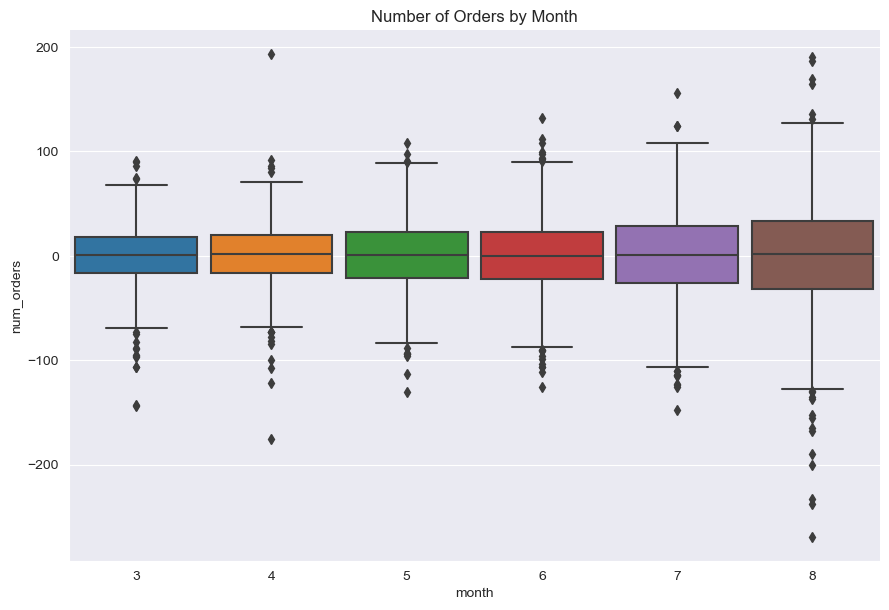

In [14]:
sns.catplot(x="month", y="num_orders", kind="box", data=df_diff, width=0.9, height=6, aspect=1.5)
plt.title("Number of Orders by Month")
plt.show()

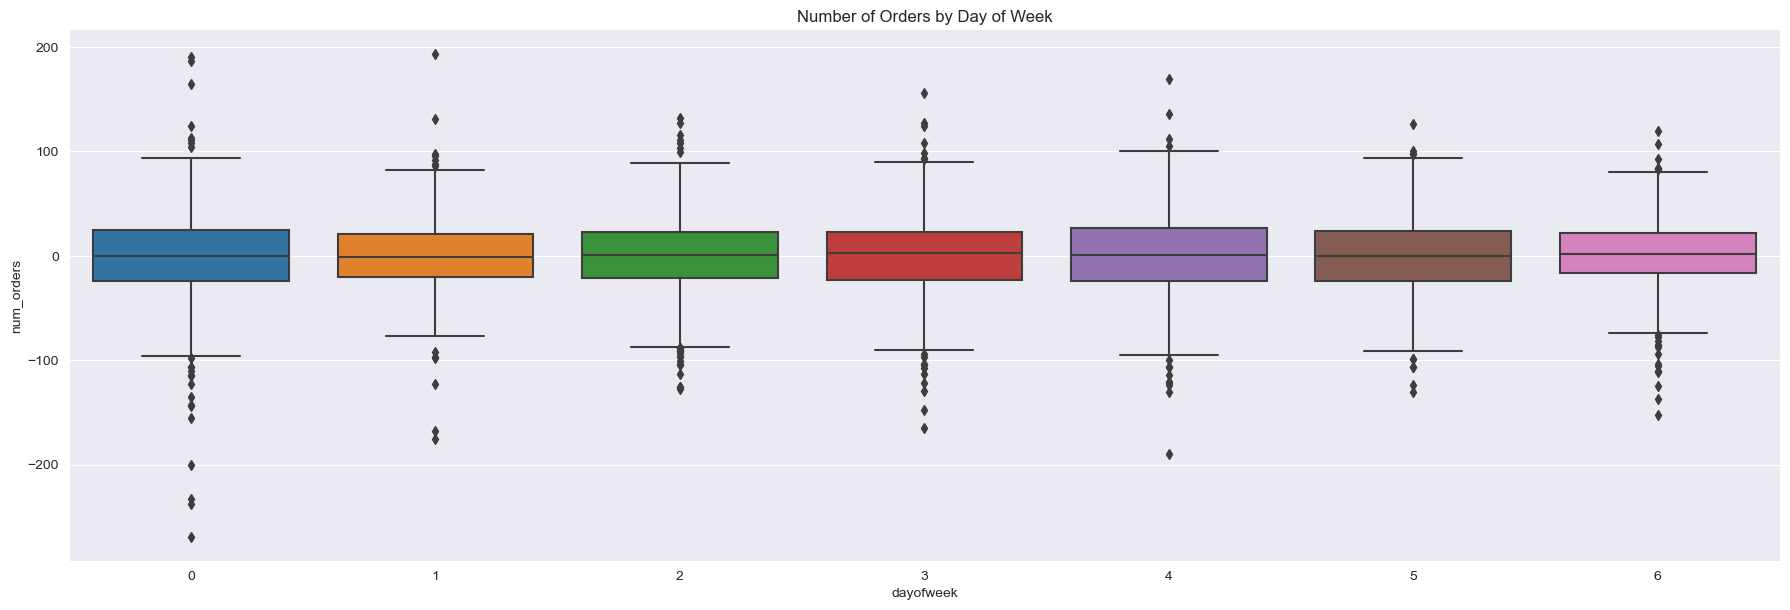

In [15]:
sns.catplot(x="dayofweek", y="num_orders", kind="box", data=df_diff, width=0.8, height=6, aspect=3)
plt.title("Number of Orders by Day of Week")
plt.show()

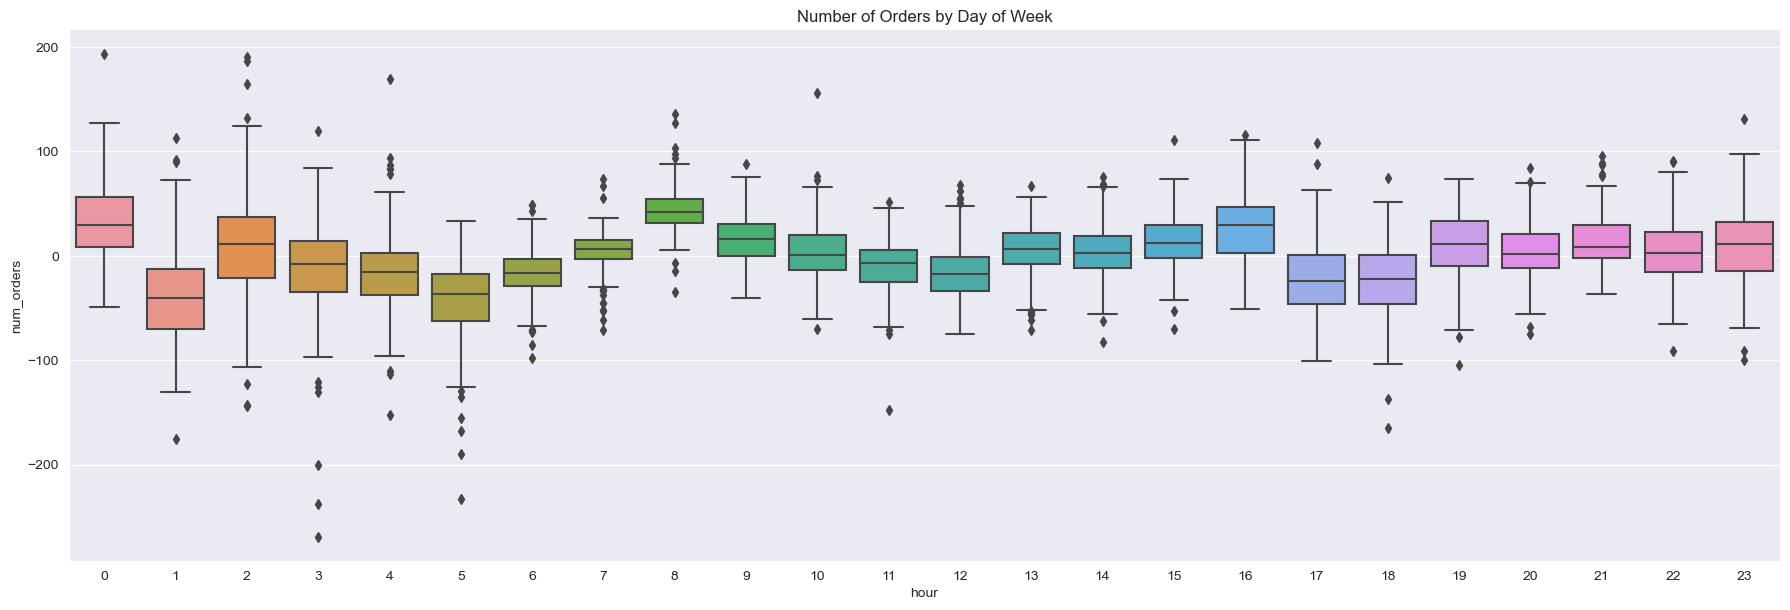

In [16]:
sns.catplot(x="hour", y="num_orders", kind="box", data=df_diff, width=0.8, height=6, aspect=3)
plt.title("Number of Orders by Day of Week")
plt.show()

Based on the plots above, the time series is stationary now. Next the models will be built.

## Training the models

In [17]:
# set constants and cross-validation strategy
random_state = 42
tscv = TimeSeriesSplit(n_splits=5)

In [18]:
# split data into train, valid, test
train, test = train_test_split(df_diff, shuffle=False, test_size=0.2)
valid, test = train_test_split(test, shuffle=False, test_size=0.5)
train.dropna(inplace=True)

X_train = train.drop(columns='num_orders')
y_train = train.num_orders

X_valid = valid.drop(columns='num_orders')
y_valid = valid.num_orders 

X_test = test.drop(columns='num_orders')
y_test = test.num_orders


In [19]:
# Print the sizes of the datasets
print(f'Training set size: {X_train.shape[0]}')
print(f'Validation set size: {X_valid.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')
print(f'Target training set size: {y_train.shape[0]}')
print(f'Target validation set size: {y_valid.shape[0]}')
print(f'Target test set size: {y_test.shape[0]}')
print(f'Total: {X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]}')

Training set size: 3507
Validation set size: 442
Test set size: 442
Target training set size: 3507
Target validation set size: 442
Target test set size: 442
Total: 4391


### Linear Regression

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_valid)
rmse_lr = mean_squared_error(y_valid, y_pred_lr, squared=False)

print(f'Linear Regression RMSE: {rmse_lr:.4f}')

Linear Regression RMSE: 34.2955


### Decision Tree

In [21]:
# create the decision tree model
dt = DecisionTreeRegressor(random_state=random_state)

# Define the hyperparameters to tune
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [2, 4, 6, 8, 10],
}

# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(
    dt, 
    param_grid, 
    cv=tscv, 
    scoring='neg_root_mean_squared_error', 
    verbose=1, n_jobs=-1,
    )
grid_search.fit(X_train, y_train)

# get the best hyperparameters
best_params_dt = grid_search.best_params_
best_dt_model = grid_search.best_estimator_

# make predictions on the validation set and score using RMSE
print(f'Best Decision Tree hyperparameters: {best_params_dt}')
y_pred_dt = best_dt_model.predict(X_valid)
rmse_dt = mean_squared_error(y_valid, y_pred_dt, squared=False)
print(f'Decision Tree RMSE: {rmse_dt:.2f}')


Fitting 5 folds for each of 140 candidates, totalling 700 fits
Best Decision Tree hyperparameters: {'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 2}
Decision Tree RMSE: 38.24


### Random Forest Model

In [22]:
# create the random forest model
rf = RandomForestRegressor(random_state=random_state)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [150, 200, 250, 275, 300, 325, 350],
    'max_depth': [2, 6, 8, 12, 14, 16, 18, 20],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(
    rf, 
    param_grid, 
    cv=tscv, 
    scoring='neg_root_mean_squared_error', 
    verbose=1, n_jobs=-1,
    )
grid_search.fit(X_train, y_train)

# get the best hyperparameters
best_params_rf = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

# make predictions on the validation set and score using RMSE
print(f'Best Random Forest hyperparameters: {best_params_rf}')
y_pred_rf = best_rf_model.predict(X_valid)
rmse_rf = mean_squared_error(y_valid, y_pred_rf, squared=False)
print(f'Random Forest RMSE: {rmse_rf:.2f}')


Fitting 5 folds for each of 840 candidates, totalling 4200 fits
Best Random Forest hyperparameters: {'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 325}
Random Forest RMSE: 35.41


### Light GBM

In [23]:
# create the lightGBM model
model_lgbm = LGBMRegressor(force_row_wise=True, verbosity=-1, random_state=random_state)

# Define the hyperparameters to tune
param_grid = {
    'max_depth': [5, 10, 15, 20, 25, 30],
    'num_leaves': [10, 20, 30, 40, 50],
    'min_child_samples': [1, 5, 10, 15, 20],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
}

# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(
    model_lgbm, 
    param_grid, 
    cv=tscv, 
    scoring='neg_root_mean_squared_error', 
    verbose=1, n_jobs=-1
)
grid_search.fit(X_train, y_train)

# get the best hyperparameters
best_params_lgbm = grid_search.best_params_
best_lgbm_model = grid_search.best_estimator_

# make predictions on the validation set and score using RMSE
print(f'Best Decision Tree hyperparameters: {best_params_lgbm}')
y_pred_lgbm = best_lgbm_model.predict(X_valid)
rmse_lgbm = mean_squared_error(y_valid, y_pred_lgbm, squared=False)
print(f'LightGBM RMSE: {rmse_lgbm:.2f}')


Fitting 5 folds for each of 600 candidates, totalling 3000 fits
Best Decision Tree hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'num_leaves': 20}
LightGBM RMSE: 32.99


### XGBoost Model

In [24]:
# create the xgboost model
model_xgb = XGBRegressor(random_state=random_state, verbosity=0)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [5, 8, 10],
    'min_child_weight': [1, 5, 10]
}

# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(
    model_xgb, 
    param_grid, 
    cv=tscv, 
    scoring='neg_root_mean_squared_error', 
    verbose=1, n_jobs=-1,
)
grid_search.fit(X_train, y_train)

# get the best hyperparameters
best_params_xgb = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

# make predictions on the validation set and score using RMSE
print(f'Best XGBoost hyperparameters: {best_params_xgb}')
y_pred_xgb = best_xgb_model.predict(X_valid)
rmse_xgb = mean_squared_error(y_valid, y_pred_xgb, squared=False)
print(f'XGBoost RMSE: {rmse_xgb:.2f}')

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best XGBoost hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 300}
XGBoost RMSE: 32.84


In [25]:
# Apply the tuned models to the test set and calculate RMSE
y_pred_test_lr = lr.predict(X_test)
rmse_lr_test = mean_squared_error(y_test, y_pred_test_lr, squared=False)

y_pred_dt_test = best_dt_model.predict(X_test)
rmse_dt_test = mean_squared_error(y_test, y_pred_dt_test, squared=False)

y_pred_rf_test = best_rf_model.predict(X_test)
rmse_rf_test = mean_squared_error(y_test, y_pred_rf_test, squared=False)

y_pred_lgbm_test = best_lgbm_model.predict(X_test)
rmse_lgbm_test = mean_squared_error(y_test, y_pred_lgbm_test, squared=False)

y_pred_xgb_test = best_xgb_model.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb_test, squared=False)


In [27]:
# create a dataframe with the model names and their RMSE scores
models_compare = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'LightGBM', 'XGBoost'],
    'Validation RMSE': [rmse_lr, rmse_dt, rmse_rf, rmse_lgbm, rmse_xgb],
    'Test RMSE': [rmse_lr_test, rmse_dt_test, rmse_rf_test, rmse_lgbm_test, rmse_xgb_test]
})

display(models_compare)

,Model,Validation RMSE,Test RMSE
0,Linear Regression,34.295461,45.323720
1,Decision Tree,38.239279,50.917244
2,Random Forest,35.405490,47.197580
3,LightGBM,32.985501,44.372615
4,XGBoost,32.843359,44.005591


### Retraining the models with sequential data

The best models are the LightGBM and the XGBoost models, with an RMSE of around 44. This is a fairly good score, but some error may be attributed to the fact that the training and test models are not sequential. By combining the training and validation sets, we can get a more accurate score. We will retrain the models with the same parameters and see if the score improves.

In [28]:
# linear regression
lr = LinearRegression()
lr.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))

y_pred_lr = lr.predict(X_test)
rmse_lr_concat = mean_squared_error(y_test, y_pred_lr, squared=False)

print(f'Linear Regression RMSE: {rmse_lr_concat:.4f}')

Linear Regression RMSE: 45.0652


In [29]:
# create the decision tree model
dt = DecisionTreeRegressor(random_state=random_state)
dt.set_params(**best_params_dt)

dt.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))

y_pred_dt = dt.predict(X_test)
rmse_dt_concat = mean_squared_error(y_test, y_pred_dt, squared=False)
print(f'Decision Tree RMSE: {rmse_dt_concat:.2f}')

Decision Tree RMSE: 51.01


In [30]:
# create the random forest model
rf = RandomForestRegressor(random_state=random_state)
rf.set_params(**best_params_rf)

# fit the model
rf.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))

# predict
y_pred_rf = rf.predict(X_test)
rmse_rf_concat = mean_squared_error(y_test, y_pred_rf, squared=False)
print(f'Random Forest RMSE: {rmse_rf_concat:.2f}')

Random Forest RMSE: 46.54


In [31]:
# create the lightGBM model
model_lgbm = LGBMRegressor(force_row_wise=True, verbosity=-1, random_state=random_state)
model_lgbm.set_params(**best_params_lgbm)

# fit the model
model_lgbm.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))

# predict the model
y_pred_lgbm = model_lgbm.predict(X_test)
rmse_lgbm_concat = mean_squared_error(y_test, y_pred_lgbm, squared=False)
print(f'LightGBM RMSE: {rmse_lgbm_concat:.2f}')

LightGBM RMSE: 42.59


In [32]:
# create the xgboost model
model_xgb = XGBRegressor(random_state=random_state, verbosity=0)
model_xgb.set_params(**best_params_xgb)

# fit the model
model_xgb.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))

# predict
y_pred_xgb = model_xgb.predict(X_test)
rmse_xgb_concat = mean_squared_error(y_test, y_pred_xgb, squared=False)
print(f'XGBoost RMSE: {rmse_xgb_concat:.2f}')

XGBoost RMSE: 42.33


In [33]:
rmse_test_concat = [rmse_lr_concat, rmse_dt_concat, rmse_rf_concat, rmse_lgbm_concat, rmse_xgb_concat]

In [34]:
models_compare['Concat_RMSE'] = rmse_test_concat

In [35]:
display(models_compare)

,Model,Validation RMSE,Test RMSE,Concat_RMSE
0,Linear Regression,34.295461,45.323720,45.065221
1,Decision Tree,38.239279,50.917244,51.013923
2,Random Forest,35.405490,47.197580,46.536750
3,LightGBM,32.985501,44.372615,42.594308
4,XGBoost,32.843359,44.005591,42.334654


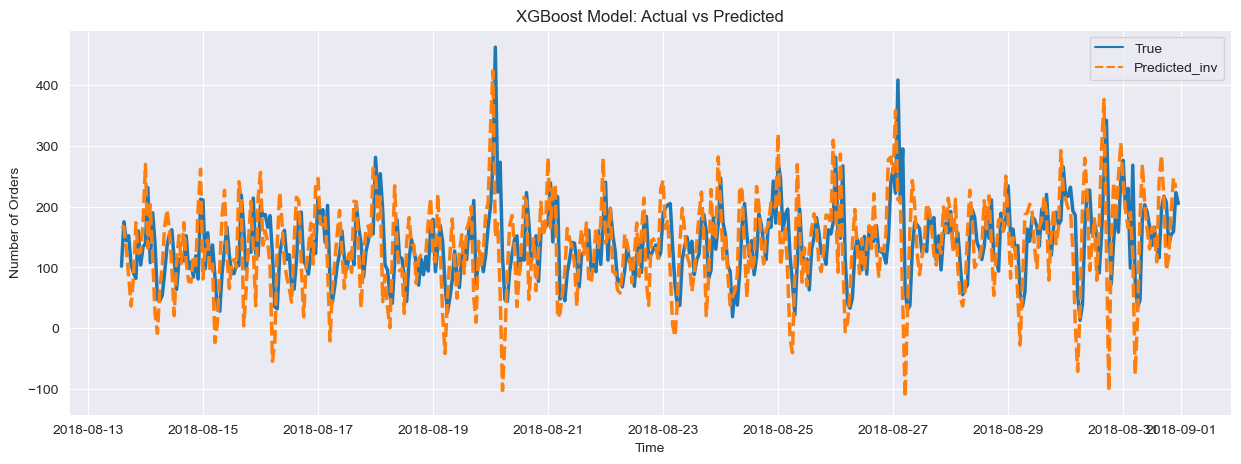

In [36]:
# Collect the prediction results of the XGBoost model and compare to the actual values
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_xgb})

result_df = pd.merge(result_df, df, left_index=True, right_index=True)
result_df.rename(columns={'num_orders': 'True'}, inplace=True)
result_df['Predicted_inv'] = result_df['Predicted'] + result_df['True'].shift(-1)

plt.figure(figsize=(15, 5))
sns.lineplot(data=result_df[['True', 'Predicted_inv']], palette="tab10", linewidth=2.5)
plt.title('XGBoost Model: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Number of Orders')
plt.grid(True)

plt.show()

## Conclusion

In this project, we have built a model for predicting the number of taxi orders for the next hour. After cleaning and differencing the data, we have trained the model on the data from the past six months. The best model is the XGBoost model, and the RMSE score is 42.33, which is less than 48, the threshold value. 

Using the XGBoost model, Sweet Lift Taxi Company can reliably predict the number of taxi orders for the next hour. The company can use this information to distribute the drivers more efficiently and plan the number of drivers needed for the next hour, which will allow them to reduce the waiting time for passengers, adjust the number of drivers on duty, and improve customer satisfaction.